In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import Counter
import numpy as np
import matplotlib.patches as mpatches

%matplotlib inline

In [214]:
'''

Take in logging_file_init + logging_file_tree + clusered_db + optional cluster_id
Generate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)
Get one cluster (by ID or at random)

For a particular cluster...
Get the .fasta files from genbank associated with all seqs

For each pair of removed/retained seqs...
Remove stretches of Ns from .fasta files
Simulate reads
Align with minimap2 to retained seq
Align with minimap2 to clustered DB
Return (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)

Optional: align to retained seq, get metrics 
    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)


'''

'\n\nTake in logging_file_init + logging_file_tree + clusered_db + optional cluster_id\nGenerate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)\nGet one cluster (by ID or at random)\n\nFor a particular cluster...\nGet the .fasta files from genbank associated with all seqs\n\nFor each pair of removed/retained seqs...\nRemove stretches of Ns from .fasta files\nSimulate reads\nAlign with minimap2 to retained seq\nAlign with minimap2 to clustered DB\nReturn (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)\n\nOptional: align to retained seq, get metrics \n    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)\n\n\n'

In [215]:
# required parameters to specify inputs/outputs
logging_file_init = './data/logging_contained_in_chunk_rhino.tsv' #'./data/logging_contained_in_chunk_chkv.tsv'
logging_file_tree = './data/logging_contained_in_tree_rhino.tsv' #'./data/logging_contained_in_tree_chkv.tsv'
clustered_db = './data/nt_compressed_compressed_rhino_dump.fa' #'./data/nt_compressed_compressed_chkv_dump.fa'
#cluster_id = #'ON023526.1' #'HM045820.1' #'OP485450.1' #chkv clusters
cluster_id = 'JQ837720.1' #'MZ629115.1'

output_dir = './output1/' # this will contain all downloaded seqs and resulting analyses

In [216]:
# read in the logging files
log_init_df = pd.read_csv(logging_file_init, sep='\t')
log_tree_df = pd.read_csv(logging_file_tree, sep='\t')

In [217]:
# configure the logging files so that we can generate statistics on them 

def split_double_log_values(log_df):
    '''
    in cases where _retained_ is actually two (or more) entries...
    just take the last entry and the associated containment value
    '''
    log_df['retained'] = [i.split(',')[-1] for i in list(log_df['retained'])]
    print(type(log_df['containment'][0]))
    try:
        log_df['containment'] = [i.split(',')[-1] for i in list(log_df['containment'])]
    except:
        print('no double log values found')
    log_df['containment'] = pd.to_numeric(log_df['containment'])
    return(log_df)

log_init_df = split_double_log_values(log_init_df)
log_tree_df = split_double_log_values(log_tree_df)

<class 'str'>
<class 'numpy.float64'>
no double log values found


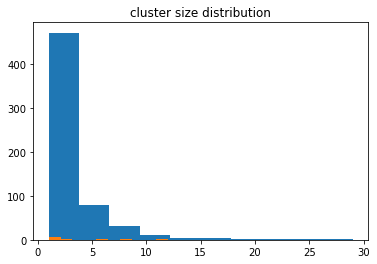

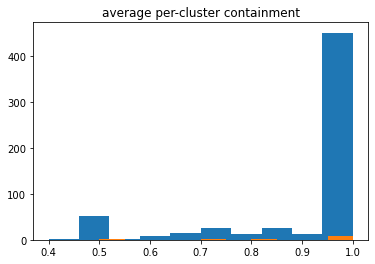

In [218]:
# plot histogram of cluster sizes
plt.hist(log_init_df.groupby('retained')['containment'].count())
plt.hist(log_tree_df.groupby('retained')['containment'].count())
plt.title("cluster size distribution")
plt.show()
# plot histogram of containment values
plt.hist(log_init_df.groupby('retained')['containment'].mean())
plt.hist(log_tree_df.groupby('retained')['containment'].mean())
plt.title("average per-cluster containment")
plt.show()

In [241]:
# combine the two cluster inputs
full_df = pd.concat([log_init_df, log_tree_df])
all_cluster_sizes = full_df.groupby('retained')['containment'].count()
all_cluster_mean_containment = full_df.groupby('retained')['containment'].mean()
all_cluster_sizes_sorted = all_cluster_sizes.sort_values(ascending = False)
all_cluster_sizes_sorted.head()

retained
MH460228.1    29
OK017923.1    28
MZ460700.1    25
KX831274.1    23
LC591789.1    20
Name: containment, dtype: int64

In [ ]:
# plot to evaluate relationships between mean containment and cluster size 
# conclusion: most of the clusters with really low mean containment have just a few members in them 
plt.scatter(all_cluster_sizes, all_cluster_mean_containment, alpha = .5)
plt.title("relationship between mean containment and cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean containment")
plt.show()

In [220]:
# select just one cluster to investigate (based on input)
current_cluster_df = full_df[[cluster_id in i for i in list(full_df['retained'])]]

# select just one cluaster (based on size)
#top_cluster = str(all_cluster_sizes.head(1).index).split('|')[-2]
#current_cluster_df = full_df[[top_cluster in i for i in list(full_df['retained'])]]

# select the cluster with the lowest mean containment 
#lowest_containment_cluster = full_df.groupby('retained')['containment'].mean().sort_values().head(1).index[0]
#current_cluster_df = full_df[[lowest_containment_cluster in i for i in list(full_df['retained'])]]

In [221]:
full_df.groupby('retained')['containment'].mean().sort_values()

retained
KY369882.1    0.400000
MK989754.1    0.428571
JQ837720.1    0.472222
KF970869.1    0.500000
LC004831.1    0.500000
                ...   
KU237122.1    1.000000
KU237072.1    1.000000
KU237062.1    1.000000
KY006420.1    1.000000
OQ331222.1    1.000000
Name: containment, Length: 613, dtype: float64

In [222]:
# NOTE: keep an eye here based on log file structure! may need to modify this
try: 
    # this is necessary given header structure for CHKV log
    current_cluster_df['seq_id'] = [i.split('|')[-2] for i in current_cluster_df['discarded']]
except: 
    # rhinovirus header structure differed, so this works for that case
    current_cluster_df['seq_id'] = [i for i in current_cluster_df['discarded']]
current_cluster_df

<ipython-input-222-4c1c7484fb2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster_df['seq_id'] = [i for i in current_cluster_df['discarded']]


,discarded,retained,containment,seq_id
1222,JN815244.1,JQ837720.1,0.444444,JN815244.1
1223,JN815240.1,JQ837720.1,0.500000,JN815240.1


In [223]:
# NOTE: keep an eye here based on log file structure! may need to modify this


# get all sequence names...
try:
    discarded_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['discarded'])]))
    retained_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['retained'])]))
except:
    discarded_seqs = list(set([i for i in list(current_cluster_df['discarded'])]))
    retained_seqs = list(set([i for i in list(current_cluster_df['retained'])]))
all_seq_ids = {'discarded': discarded_seqs, 'retained':retained_seqs}
all_seq_ids_list = discarded_seqs + retained_seqs

In [224]:
''' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)
! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"
! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook
'''

' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)\n! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"\n! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook\n'

In [225]:
# create an output directory based on initial input
! mkdir {output_dir}

mkdir: ./output1/: File exists


In [226]:
# Get the .fasta files from genbank associated with all seqs
for this_seq in all_seq_ids_list:
    print(this_seq)
    print("working...")
    ! /Users/katrina.kalantar/edirect/esearch -db nucleotide -query {this_seq} | /Users/katrina.kalantar/edirect/efetch -format fasta > {output_dir}{this_seq}.fasta


JN815244.1
working...
JN815240.1
working...
JQ837720.1
working...


In [227]:
# create the simulated files needed for alignment experiment!!

for this_seq in all_seq_ids_list:
    records = list(SeqIO.parse(output_dir + this_seq + '.fasta', "fasta"))
    this_sequence = str(records[0].seq)    
    new_record = SeqRecord(Seq(this_sequence.replace('NNNNN', '')), 
                           id=records[0].id, 
                           name=records[0].name, description=records[0].description)
    
    # write the new, no-Ns fasta sequence to a new file
    noN_filename = output_dir + this_seq + 'noN.fasta'
    SeqIO.write(new_record, noN_filename, "fasta")
    
    ! iss generate --genomes {noN_filename} --model miseq --output {output_dir + this_seq}.miseq_reads --n_reads 10000
    

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 10000 reads
INFO:iss.app:Generating reads for record: JN815244.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete
INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 10000 reads
INFO:iss.app:Generating reads for record: JN815240.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete
INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitchi

In [228]:
# run the alignment experiment for each discarded sequence and gather metrics

ref_seq = output_dir + all_seq_ids['retained'][0] + '.fasta'

results_dict = {}

for this_seq in all_seq_ids['discarded']:
    print(this_seq)
    input_r1 = output_dir + this_seq + '.miseq_reads_R1.fastq'
    input_r2 = output_dir + this_seq + '.miseq_reads_R2.fastq'
    
    results_dict[this_seq] = {}
    
    # align reads only to the retained seq
    ! minimap2 -ax sr {ref_seq} {input_r1} {input_r2} > {output_dir + this_seq}.alnseq.sam
    ! samtools stats {output_dir + this_seq}.alnseq.sam > {output_dir + this_seq}.alnseq.stats.txt
    unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alnseq.stats.txt
    unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
    results_dict[this_seq]['seqmap'] = unmapped_reads_count
    print(unmapped_reads_count)
    
    # align reads to the full clustered DB
    ! minimap2 -ax sr {clustered_db} {input_r1} {input_r2} > {output_dir + this_seq}.alndb.sam
    ! samtools stats {output_dir + this_seq}.alndb.sam > {output_dir + this_seq}.alndb.stats.txt
    unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alndb.stats.txt
    unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
    results_dict[this_seq]['dbmap'] = unmapped_reads_count
    print(unmapped_reads_count)
    
    containment = current_cluster_df[current_cluster_df.seq_id==this_seq]['containment'].iloc[0]
    results_dict[this_seq]['containment'] = containment
   
    print(results_dict[this_seq])
    print("\n\n")


JN815244.1
[M::mm_idx_gen::0.001*21.56] collected minimizers
[M::mm_idx_gen::0.002*12.79] sorted minimizers
[M::main::0.002*12.50] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*12.46] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*11.87] distinct minimizers: 1016 (100.00% are singletons); average occurrences: 1.000; average spacing: 6.651; total length: 6757
[M::worker_pipeline::0.159*2.51] mapped 10000 sequences
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -ax sr ./output1/JQ837720.1.fasta ./output1/JN815244.1.miseq_reads_R1.fastq ./output1/JN815244.1.miseq_reads_R2.fastq
[M::main] Real time: 0.160 sec; CPU: 0.400 sec; Peak RSS: 0.010 GB
436
[ERROR] failed to open file './data/nt_compressed_compressed_rhino_dump.fa': No such file or directory
0
{'seqmap': 436, 'dbmap': 0, 'containment': 0.4444444444444444}



JN815240.1
[M::mm_idx_gen::0.001*19.94] collected minimizers
[M::mm_idx_gen::0.002*13.3

In [229]:
mapping_results_df = pd.DataFrame.from_dict(results_dict, orient='index')
mapping_results_df

,seqmap,dbmap,containment
JN815244.1,436,0,0.444444
JN815240.1,518,0,0.500000


In [230]:
# OPTIONAL -- do pairwise sequence alignment and investigate the output

ref_seq = output_dir + all_seq_ids['retained'][0] + '.fasta'
all_results = {}

for this_seq in all_seq_ids['discarded']:
    ! cat {ref_seq} {output_dir + this_seq}.fasta > {output_dir + this_seq}.muscle.fasta
    ! muscle -in {output_dir + this_seq}.muscle.fasta -out {output_dir + this_seq}.aln 
    
    
    
    records = list(SeqIO.parse( output_dir + this_seq + ".aln", "fasta"))   
    
    
    seq_ref = str(records[0].seq)
    seq_b = str(records[1].seq)
    
    pairs = []
    for i in range(len(seq_ref)):
        pairs.append(seq_ref[i] + '/' + seq_b[i])

    tally = Counter(pairs)

    result={}

    result['ESref'] = tally['-/A'] + tally['-/C'] + tally['-/G'] + tally['-/T']
    result['ESb'] = tally['A/-'] + tally['C/-'] + tally['G/-'] + tally['T/-']
    result['ENref'] = tally['N/-'] 
    result['ENb'] = tally['-/N'] 
    result['Nref'] = tally['N/A'] + tally['N/C'] + tally['N/G'] + tally['N/T']
    result['Nb'] = tally['A/N'] + tally['G/N'] + tally['C/N'] + tally['T/N']
    result['match'] = tally['A/A'] + tally['G/G'] + tally['C/C'] + tally['T/T']
    result['mismatch'] = tally['A/C'] + tally['A/G'] + tally['A/T'] + tally['C/A'] + tally['C/G'] + tally['C/T'] + tally['G/A'] + tally['G/C'] + tally['G/T'] + tally['T/A'] + tally['T/C'] + tally['T/G']
    result['alignment length'] = len(seq_ref)
    result['seq_length'] = len(seq_b.replace('-',''))
    
    result['pid'] = np.round(result['match'] / (result['match'] + result['mismatch'] ), 3)
    print(result)
    
    all_results[this_seq] = result
    
    print("\n\n")
    


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

JN815244.1.muscle 2 seqs, lengths min 6757, max 6911, avg 6834
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:01     63 MB(0%)  Iter   1  100.00%  Align node       
00:00:01     63 MB(0%)  Iter   1  100.00%  Root alignment
{'ESref': 181, 'ESb': 169, 'ENref': 418, 'ENb': 560, 'Nref': 15, 'Nb': 230, 'match': 5653, 'mismatch': 272, 'alignment length': 7498, 'seq_length': 6911, 'pid': 0.954}




MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

JN815240.1.muscle 2 seqs, lengths min 6757, max 6794, avg 6775
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist

In [231]:
pairwise_results_df = pd.DataFrame.from_dict(all_results, orient='index')
pairwise_results_df

,ESref,ESb,ENref,ENb,Nref,Nb,match,mismatch,alignment length,seq_length,pid
JN815244.1,181,169,418,560,15,230,5653,272,7498,6911,0.954
JN815240.1,75,129,11,102,422,0,6005,190,6934,6794,0.969


In [232]:
joint_results_df = pd.concat([mapping_results_df, pairwise_results_df], axis=1)
joint_results_df.sort_values(by='containment', ascending = True, inplace=True)
joint_results_df

,seqmap,dbmap,containment,ESref,ESb,ENref,ENb,Nref,Nb,match,mismatch,alignment length,seq_length,pid
JN815244.1,436,0,0.444444,181,169,418,560,15,230,5653,272,7498,6911,0.954
JN815240.1,518,0,0.500000,75,129,11,102,422,0,6005,190,6934,6794,0.969


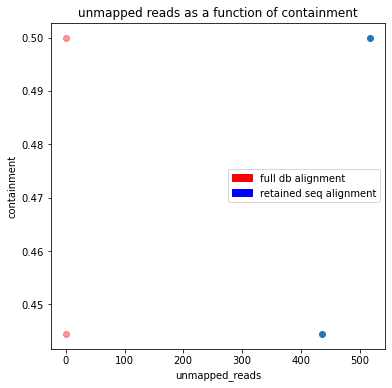

In [233]:
plt.figure(figsize=(6,6))
plt.scatter(joint_results_df['seqmap'], joint_results_df['containment'], zorder=0)
plt.scatter(joint_results_df['dbmap'], joint_results_df['containment'], zorder=1, color='red', alpha=.4)
plt.xlabel('unmapped_reads')
plt.ylabel('containment')
plt.title('unmapped reads as a function of containment')

red_patch = mpatches.Patch(color='red', label='full db alignment')
blue_patch = mpatches.Patch(color='blue', label='retained seq alignment')
plt.legend(handles=[red_patch, blue_patch])

#plt.scatter(x1,y1,marker = 'o', s = 6, color = 'r', zorder=1)

#ax1 = joint_results_df[['seqmap', 'containment']].plot(kind='scatter', x= 'seqmap', y='containment')
#joint_results_df[['dbmap', 'containment']].plot(kind='scatter', x= 'dbmap', y='containment', axis=ax1)